## Readme

This script scrapes reviews from Trustpilot, for a given company.

There is exploratory analysis of:
- Average ratings by location
- Days between experiences and reviews

There is topic modelling to identify themes

There is sentiment analysis to assign a positive/negative sentiment score to the review content. NB this performs much worse than the given review score.

There is keyword analysis to identify the most prevalent words and n-grams (pair combinations of words)

Data is then exported to a csv file, with a timestamp

## Import Libraries

In [1]:
### IMPORT LIBRARIES

from datetime import datetime, timedelta
from time import sleep
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text 
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress the ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

## Define Functions

In [2]:
## DEFINE BEAUTIFUL SOUP FUNCTION, SETUP ARRAYS

def soup2list(src, list_, attr=None):
    if attr:
        for val in src:
            list_.append(val[attr])
    else:
        for val in src:
            list_.append(val.get_text())
    
users = []
userReviewNum = []
ratings = []
locations = []
dates = []
reviews = []

from_page = 1
to_page = 258
company = 'byway.travel'
# company = 'greatrail.com'
url_root = 'uk.trustpilot'

In [3]:
## DEFINE FUNCTION TO CONVERT 'X DAYS AGO' TO A DATE

def convert_days_ago_to_date(days_ago):
    try:
        days = int(days_ago.split()[0])
        new_date = datetime.now() - timedelta(days=days)
        return new_date.strftime("%Y-%m-%d")
    except ValueError:
        return days_ago


In [4]:
# DEFINE Function to convert review date texts into Python datetime objects

# Function to convert review date texts into Python datetime objects
def convert_review_date(review_date_text):
    review_date_text = review_date_text.replace("Invited", "").strip()
    review_date_text = review_date_text.replace("Updated ", "").lower()
    
    #print("Processing:", review_date_text)  # Add this line to print the processed text
    
    if "hours ago" in review_date_text or "hour ago" in review_date_text:
        return datetime.now().date()
    elif "a day ago" in review_date_text:
        return datetime.now().date() - timedelta(days=1)
    elif "days ago" in review_date_text:
        return datetime.now().date() - timedelta(days=int(review_date_text.split()[0]))
    else:
        try:
            # Attempt to parse the date with and without the trailing text
            return datetime.strptime(review_date_text, "%d %b %Y").date()
        except ValueError:
            # Handle cases where the date format doesn't match the expected format
            return None

In [5]:
## BEAUTIFUL SOUP SCRAPING FUNCTION

for i in range(from_page, to_page+1):

   result = requests.get(fr"https://{url_root}.com/review/{company}?page={i}")
   soup = BeautifulSoup(result.content)

   # Trust Pilot was setup in a way that's not friendly to scraping, so this hacky method will do.
   soup2list(soup.find_all('span', {'class','typography_heading-xxs__QKBS8 typography_appearance-default__AAY17'}), users)
   soup2list(soup.find_all('div', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua'}), locations)
   soup2list(soup.find_all('span', attrs={"class":"typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l",
                                         "data-consumer-reviews-count-typography": "true"}), userReviewNum)
   soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), dates)
   soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), ratings, attr='data-service-review-rating')
   soup2list(soup.find_all('div', {'class','styles_reviewContent__0Q2Tg'}), reviews)
   
   # To avoid throttling
   sleep(1)

In [6]:
## CHECK ARRAYS ARE SAME LENGTH (OTHERWISE CAN'T BE JOINED TO MAKE DATAFRAME)

print(len(users), len(userReviewNum), len(locations), len(dates), len(reviews), len(ratings))

398 398 398 398 398 398


In [7]:
## CONVERT ARRAYS INTO A PANDAS DATAFRAME

df = pd.DataFrame(
{
   'Username':users,
   'Total reviews':userReviewNum,
   'location':locations,
   'date':dates,
   'content':reviews,
   'Rating': ratings
})

In [8]:
print(df.head())

          Username Total reviews location         date  \
0             RozC     3 reviews       GB   7 Jan 2024   
1  Rachelle Arnold      1 review       GB   5 days ago   
2        Stephanie    15 reviews       GB   6 Jan 2024   
3  Frances Zygmunt    19 reviews       GB   8 Jan 2024   
4            Laura     5 reviews       GB  30 Dec 2023   

                                             content Rating  
0  Great trip plan and fantastic support whilst t...      5  
1  Excellent holiday companyByway are very helpfu...      5  
2  Our second family holiday with Byways…Our seco...      5  
3  Travel up to Fort William on the…Travel up to ...      5  
4  Christmas in AlsaceThis was the first time we'...      5  


In [9]:
# Create a new column 'Review_Date2' using the provided logic
df['date'] = df['date'].apply(convert_review_date)

## Convert review date texts into Python datetime objects

In [10]:
## Extract Date of Experience from content column
df[['content', 'Date of experience']] = df['content'].str.rsplit('Date of experience: ', n=1, expand=True)

In [11]:
## Apply the function to overwrite date column
# df['date'] = df.apply(lambda row: convert_days_ago_to_date(row['date']) if row['days_ago_format'] == 1 else row['date'], axis=1)
df['Review_date'] = pd.to_datetime(df['date'], format='mixed')
df['Date_of_experience'] = pd.to_datetime(df['Date of experience'], format='mixed')
## Drop unwanted column
df = df.drop(['date', 'Date of experience'], axis=1)

## Keep only integer value of 'Total Reviews' column  
df['Total reviews'] = df['Total reviews'].replace('[^\d]', '', regex=True).astype(int)

In [12]:
### ENSURE DATATYPES ARE AS EXPECTED

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

print(df.dtypes)

Username                      object
Total reviews                  int32
location                      object
content                       object
Rating                         int64
Review_date           datetime64[ns]
Date_of_experience    datetime64[ns]
dtype: object


In [13]:
df.head()

,Username,Total reviews,location,content,Rating,Review_date,Date_of_experience
0,RozC,3,GB,Great trip plan and fantastic support whilst t...,5,2024-01-07,2023-12-28
1,Rachelle Arnold,1,GB,Excellent holiday companyByway are very helpfu...,5,2024-01-10,2023-12-22
2,Stephanie,15,GB,Our second family holiday with Byways…Our seco...,5,2024-01-06,2023-12-28
3,Frances Zygmunt,19,GB,Travel up to Fort William on the…Travel up to ...,5,2024-01-08,2024-01-05
4,Laura,5,GB,Christmas in AlsaceThis was the first time we'...,5,2023-12-30,2023-12-21


## Exploratory Analysis

In [14]:
# ##### IMPORT PLOTTING PACKAGES

# # Group by 'location' and calculate count and average of 'Rating'
# grouped_data = df.groupby('location')['Rating'].agg(['count', 'mean']).reset_index()

# # Plot the count of ratings by location
# plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
# plt.bar(grouped_data['location'], grouped_data['count'], color='skyblue')
# plt.title('Count of Ratings by Location')
# plt.xlabel('Location')
# plt.ylabel('Count')

# # Plot the average rating by location
# plt.subplot(2, 1, 2)
# plt.bar(grouped_data['location'], grouped_data['mean'], color='lightgreen')
# plt.title('Average Rating by Location')
# plt.xlabel('Location')
# plt.ylabel('Average Rating')

# plt.tight_layout()
# plt.show()

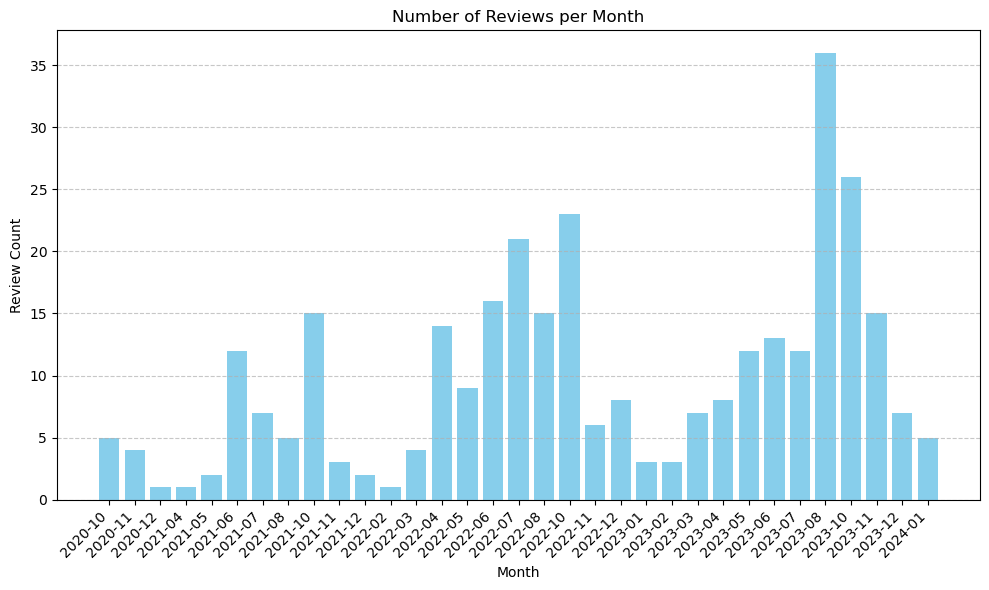

In [15]:
df['Review_date'] = pd.to_datetime(df['Review_date'])

# Extract month and year from 'Review_date'
df['Month_Year'] = df['Review_date'].dt.to_period('M')

# Group by 'Month_Year' and calculate the count of reviews
reviews_per_month = df.groupby('Month_Year').size().reset_index(name='Review_Count')

# Plot the number of reviews per month
plt.figure(figsize=(10, 6))
plt.bar(reviews_per_month['Month_Year'].astype(str), reviews_per_month['Review_Count'], color='skyblue')
plt.title('Number of Reviews per Month')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# Calculate the number of days between 'Review_date' and 'Date_of_experience'
df['Days_between'] = (df['Review_date'] - df['Date_of_experience']).dt.days

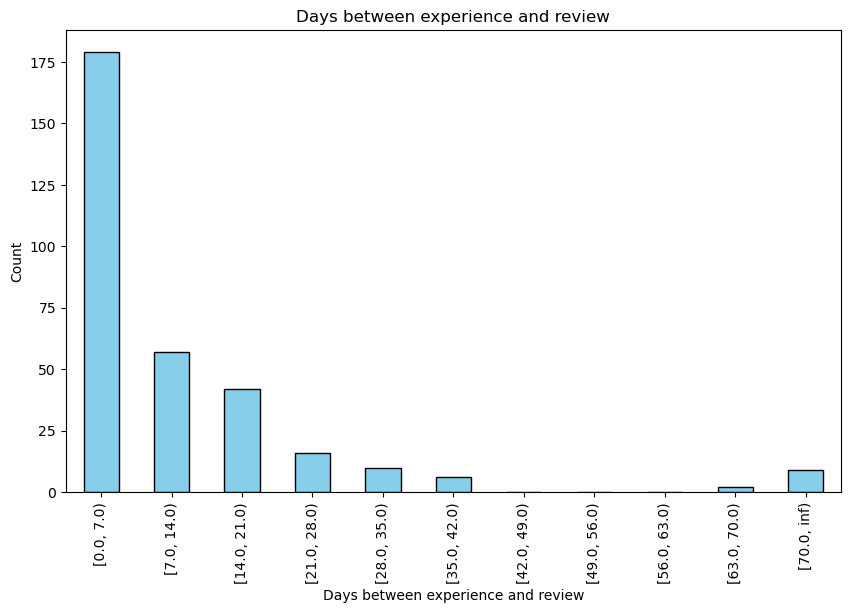

In [17]:
# Define the buckets for grouping in multiples of 7
buckets = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, float('inf')]

# Create a new column 'Days_bucket' by categorizing 'Days_between' into buckets
df['Days_bucket'] = pd.cut(df['Days_between'], bins=buckets, right=False)

# Group by 'Days_bucket' and count the frequency of each bucket
bucket_counts = df['Days_bucket'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bucket_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Days between experience and review')
plt.xlabel('Days between experience and review')
plt.ylabel('Count')
plt.show()

## Topic Modelling

Topic 1: train, time, trip, we, byway, hotels, byways, really, whatsapp, journey
Topic 2: service, excellent, use, highly, recommend, helpful, friendly, customer, again, good
Topic 3: great, trip, fantastic, team, support, organised, experience, way, wonderful, again


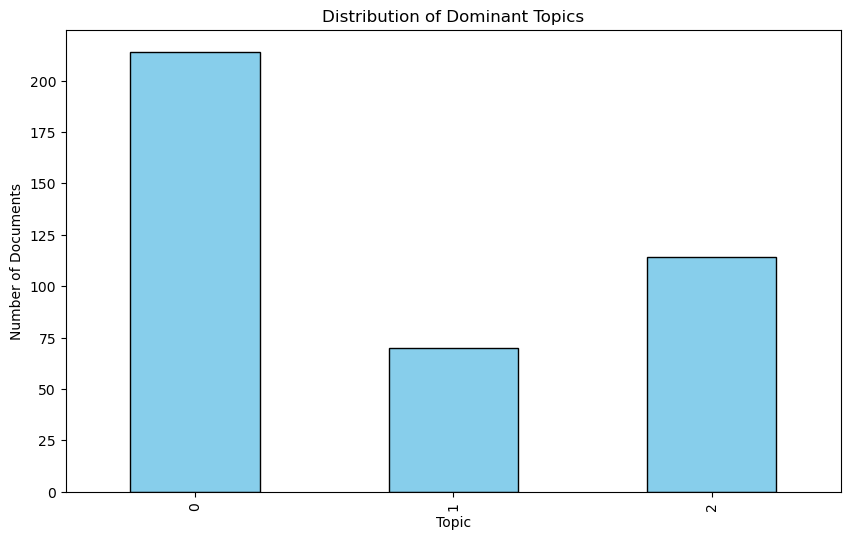

In [18]:
# Common English stop words
common_stop_words = text.ENGLISH_STOP_WORDS

# Custom stop words
custom_stop_words = ['byway', 'travel', 'holiday']

# Combine common and custom stop words
all_stop_words = set(common_stop_words).union(set(custom_stop_words))

# Create a copy of the original DataFrame
df_stop = df.copy()

# Remove custom stop words from the text in the new DataFrame
df_stop['content'] = df_stop['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in all_stop_words]))

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_stop['content'])

# Apply NMF
num_topics = 3
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Print the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for i, topic in enumerate(nmf_model.components_):
    top_words_indices = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[index] for index in top_words_indices]
    print(f"Topic {i + 1}: {', '.join(top_words)}")

# Visualize the topics
df_stop['dominant_topic'] = nmf_matrix.argmax(axis=1)

# Plot distribution of dominant topics
plt.figure(figsize=(10, 6))
df_stop['dominant_topic'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.show()

## Sentiment Analysis

In [19]:
# #### NB the sentiment analysis does a poor job of identifying negative sentiment

# ##### IMPORT SENTIMENT ANALYSIS PACKAGES

# import pandas as pd
# from textblob import TextBlob
# import nltk
# from nltk.sentiment import SentimentIntensityAnalyzer
# from nltk.tokenize import sent_tokenize
# nltk.download('punkt') # Download the 'punkt' tokenizer
# nltk.download('vader_lexicon')  # Download the VADER lexicon for SentimentIntensityAnalyzer

# # Perform sentiment analysis using TextBlob
# df['TextBlob_Sentiment'] = df['content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# # Perform sentiment analysis using NLTK's SentimentIntensityAnalyzer (VADER)
# sia = SentimentIntensityAnalyzer()
# df['NLTK_Sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# # Example plot using matplotlib
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))

# # TextBlob Sentiment
# plt.subplot(1, 2, 1)
# plt.bar(df.index, df['TextBlob_Sentiment'], color='blue')
# plt.title('TextBlob Sentiment')
# plt.xlabel('Index')
# plt.ylabel('Sentiment Score')

# # NLTK Sentiment
# plt.subplot(1, 2, 2)
# plt.bar(df.index, df['NLTK_Sentiment'], color='green')
# plt.title('NLTK Sentiment (VADER)')
# plt.xlabel('Index')
# plt.ylabel('Sentiment Score')

# plt.tight_layout()
# plt.show()


In [20]:
# #### NB the sentiment analysis does a poor job of identifying negative sentiment

# # Filter sentiment scores
# negative_sentiment_df = df[df['NLTK_Sentiment'] < 0]

# # Print the head of the DataFrame with negative sentiment scores
# print(negative_sentiment_df.head())


In [21]:
#### NB the sentiment analysis does a poor job of identifying negative sentiment

# # Create a function to analyze sentiment by sentence and aggregate for overall sentiment
# def nltk_sentiment_analysis(text):
#     sentences = sent_tokenize(text)
#     sia = SentimentIntensityAnalyzer()
    
#     # Initialize overall sentiment scores
#     compound_score = 0.0
    
#     # Analyze sentiment for each sentence
#     for sentence in sentences:
#         scores = sia.polarity_scores(sentence)
#         compound_score += scores['compound']
    
#     # Aggregate for overall sentiment
#     overall_score = compound_score / len(sentences) if len(sentences) > 0 else 0.0
#     return overall_score

# # Apply the function to 'content' column and create a new column 'NLTK_Aggregated_Sentiment'
# df['NLTK_Aggregated_Sentiment'] = df['content'].apply(nltk_sentiment_analysis)

# # Assuming 'NLTK_Aggregated_Sentiment' is the column containing aggregated sentiment scores
# negative_aggregated_sentiment_df = df[df['NLTK_Aggregated_Sentiment'] < 0]
# print(negative_aggregated_sentiment_df.head())


# Keyword Analysis

In [22]:
## IMPORT KEYWORD ANALYSIS PACKAGES

import spacy
from collections import Counter
from itertools import combinations
from nltk import ngrams

In [23]:
# Load spaCy language model
nlp = spacy.load('en_core_web_sm')

# Function to extract keywords from text
def extract_keywords(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]

# Apply the function to 'content' column and create a new column 'Keywords'
df['Keywords'] = df['content'].apply(extract_keywords)

# Flatten the list of keywords
all_keywords = [keyword for keywords in df['Keywords'] for keyword in keywords]

# Count occurrences of each keyword
keyword_counts = Counter(all_keywords)


In [24]:
##### SINGLE WORDS

# Convert the Counter to a DataFrame
keyword_df = pd.DataFrame(list(keyword_counts.items()), columns=['Keyword', 'Occurrences'])
# Sort the DataFrame by 'Occurrences' column
keyword_df = keyword_df.sort_values(by='Occurrences', ascending=False)
# Filter to keep only keywords with more than 5 occurrences
keyword_df_filtered = keyword_df[keyword_df['Occurrences'] > 5]

In [25]:
# print(keyword_df_filtered.head())

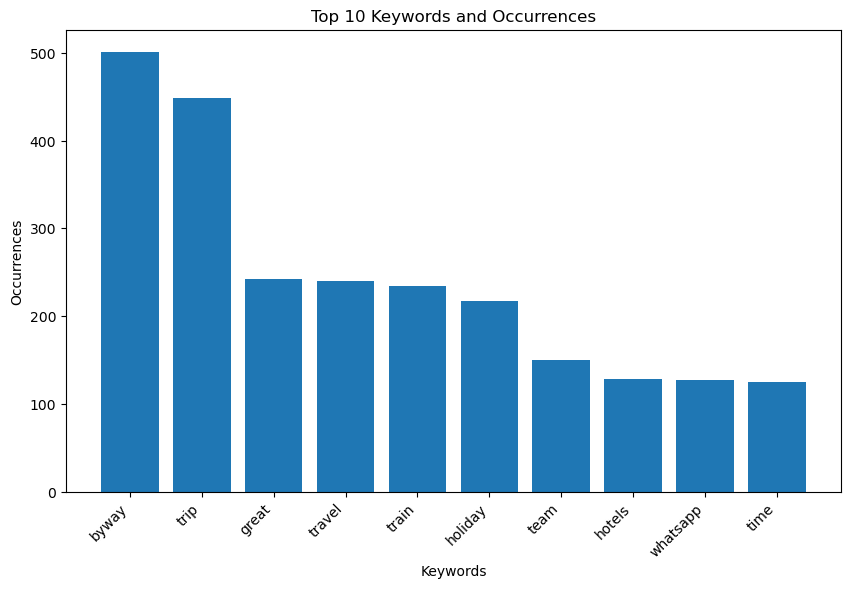

In [26]:
# Plot the top 10 keywords and their occurrences
top_10_keywords = keyword_df_filtered.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_keywords['Keyword'].astype(str), top_10_keywords['Occurrences'])
plt.title('Top 10 Keywords and Occurrences')
plt.xlabel('Keywords')
plt.ylabel('Occurrences')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

## N-Grams Analysis

In [27]:
# Function to extract key phrases from text without punctuation
def extract_key_phrases(text):
    doc = nlp(text)
    words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
    return list(ngrams(words, 2))  # Change 2 to 3 for trigrams

# Extract key phrases (consecutive word sequences without punctuation)
key_phrases = [phrase for text in df['content'] for phrase in extract_key_phrases(text)]
key_phrases_counts = Counter(key_phrases)

# Convert the Counter for key phrases to a DataFrame
key_phrases_df = pd.DataFrame(list(key_phrases_counts.items()), columns=['Key_Phrase', 'Occurrences'])

# Sort the DataFrame by 'Occurrences' column
key_phrases_df = key_phrases_df.sort_values(by='Occurrences', ascending=False)

# Filter to keep only key phrases with more than 1 occurrences
key_phrases_df_filtered = key_phrases_df[key_phrases_df['Occurrences'] > 1]

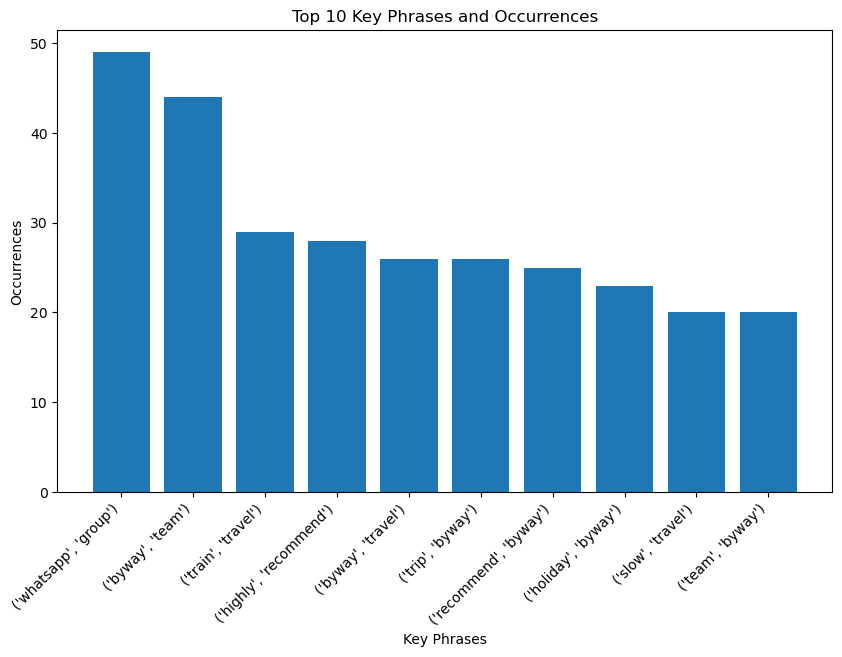

In [28]:
# Plot the top 10 key phrases and their occurrences
top_10_key_phrases = key_phrases_df_filtered.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_key_phrases['Key_Phrase'].astype(str), top_10_key_phrases['Occurrences'])
plt.title('Top 10 Key Phrases and Occurrences')
plt.xlabel('Key Phrases')
plt.ylabel('Occurrences')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

## Export data to csv

In [29]:
# #### EXPORT THE REVIEW OUTPUTS FILE

import os  

# Create a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the directory if it doesn't exist
output_directory = 'CSV_Outputs/Byway'
os.makedirs(output_directory, exist_ok=True)

# Create the file name with a timestamp
file_name = f'BywayReviews_{timestamp}.csv'

# Save the DataFrame to CSV with the timestamped file name
df.to_csv(os.path.join(output_directory, file_name), index=False)

In [30]:
# # #### EXPORT THE REVIEW OUTPUTS FILE

# import os  

# # Create a timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# # Create the directory if it doesn't exist
# output_directory = 'CSV_Outputs/GRJ'
# os.makedirs(output_directory, exist_ok=True)

# # Create the file name with a timestamp
# file_name = f'GreatRailJourneys_{timestamp}.csv'

# # Save the DataFrame to CSV with the timestamped file name
# df.to_csv(os.path.join(output_directory, file_name), index=False)